In [1]:
import cv2
from pathlib import Path
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imutils

%reload_ext autoreload
%autoreload 2
from main import (getROIFromVideo, cropWithROI, getOutputVidFrameSize, CalibWindow, 
                  getFrameFromVid, SelectionWindow, showImg)

In [2]:
vidPath = Path("data/screw/screw.mp4")
crop_roi = getROIFromVideo(str(vidPath))
cv2.destroyAllWindows()

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
# import pickle
# f = open("temp_crop.pkl", "wb")
# pickle.dump(crop_roi, f)

# f = open("temp.pkl", "rb")
# pickle.load(f)

# Perspective

In [ ]:
VID_PATH = Path("data/screw/C0003.mp4")
vs = cv2.VideoCapture(str(VID_PATH))
ret, frame = vs.read()

perspectiveWindow = SelectionWindow("Perspective", frame)
perspectiveWindow.displayWindow()

In [ ]:
objLength = 1.83
objWidth = 0.6
imgWidth = 200
imgHeight = round(objLength / objWidth * imgWidth)

srcPts = np.float32(perspectiveWindow.selectionPts)
dstPts = np.float32([(0, 0), (imgWidth, 0), (imgWidth, imgHeight), (0, imgHeight)])
M = cv2.getPerspectiveTransform(srcPts, dstPts)
dst = cv2.warpPerspective(frame, M, (imgWidth, imgHeight))

plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))

# Track

In [ ]:
VID_PATH = Path("data/pancake/IMG_2902.mp4")
OUTPUT_VID_PATH = VID_PATH.parent / (VID_PATH.stem + "_output.mp4")
OUTPUT_HEIGHT = 800
pipeline = lambda frame: frame
# pipeline = lambda frame: cv2.warpPerspective(frame, M, (imgWidth, imgHeight))
# pipeline = lambda frame: cropWithROI(frame, crop_roi)

IMSHOW_FLAG = True
WRITE_FLAG = True

cap = cv2.VideoCapture(str(VID_PATH))
fps = cap.get(cv2.CAP_PROP_FPS)

frameWidth, frameHeight = getOutputVidFrameSize(str(VID_PATH), pipeline, OUTPUT_HEIGHT)
out = cv2.VideoWriter(
    str(OUTPUT_VID_PATH),
    cv2.VideoWriter_fourcc(*"mp4v"),
    cap.get(cv2.CAP_PROP_FPS),
    (frameWidth, frameHeight),
)

totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
frameCount = 0
startTime = time.time()
saveFrames = []
saveCnts = []
centroids = []

ret, frame = cap.read()
while ret:
    if frameCount % 100 == 0 and frameCount != 0:
        elapsedTime = time.time() - startTime
        estTimeLeft = (totalFrames - frameCount) / frameCount * elapsedTime
        print(f"Frame {frameCount} out of {round(totalFrames)}.")
        print(
            f"\tTime taken: {round(elapsedTime)}s. Est. time left: {round(estTimeLeft)}s"
        )

    frame = pipeline(frame)
    frame_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    (frame_h, frame_s, frame_v) = cv2.split(frame_hsv)

    # ret, th = cv2.threshold(frame_h, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    th = cv2.inRange(frame_h, 90, 120) & cv2.inRange(frame_s, 120, 255)
    cnts, hierarchy = cv2.findContours(th, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if cnts:
        cnt = max(cnts, key=cv2.contourArea)
        M = cv2.moments(cnt)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroids.append((cX, cY))
        maxPts = 200
        dAlpha = 1 / 100
        firstPt = max(len(centroids) - maxPts, 0)
        alpha = max(maxPts - len(centroids), 0) * dAlpha
        for centroid in centroids[firstPt:]:
            frameCopy = frame.copy()
            cv2.circle(frameCopy, centroid, 5, (255, 0, 0), -1)
            frame = cv2.addWeighted(frame, 1 - alpha, frameCopy, alpha, 0)
            alpha += dAlpha
        # cv2.drawContours(frame, [cnt], -1, (255, 0, 0), 1)
        saveFrames.append(frameCount)
        saveCnts.append(cnt)

    pts = np.array(centroids).reshape((-1, 1, 2))
    frame = cv2.polylines(frame, [pts], False, (255, 0, 0), 5)

    frame = imutils.resize(frame, height=OUTPUT_HEIGHT)

    if WRITE_FLAG:
        out.write(frame)

    if IMSHOW_FLAG:
        cv2.imshow("Hue", frame_h)
        cv2.imshow("Saturation", frame_s)
        cv2.imshow("Value", frame_v)
        cv2.imshow("Detections", frame)
        key = cv2.waitKey(1)

        if key == ord("q") or key == ord("Q"):
            break

        if key == ord("p") or key == ord("P"):
            key = cv2.waitKey(0)
            if key == ord("p") or key == ord("P"):
                continue

    ret, frame = cap.read()
    frameCount += 1

cv2.destroyAllWindows()
out.release()
cap.release()

In [ ]:
# import pickle
# f = open("temp_track.pkl", "wb")
# pickle.dump([saveFrames, saveCnts], f)

# f = open("temp.pkl", "rb")
# pickle.load(f)

# Get Calibration Scale

## Select Points

In [ ]:
VID_PATH = Path("data/screw/C0003.MP4")
pipeline = lambda frame: cropWithROI(frame, crop_roi)

frame = getFrameFromVid(str(VID_PATH), 1)
img_rgb = pipeline(frame)
calibLength = 1

CalibWin = CalibWindow("Calibration", img_rgb)
CalibWin.displayWindow()
calibPoints = CalibWin.calibPoints
scale = CalibWin.getCalibScale(calibLength)
key = cv2.waitKey(0)
print(f"Scale is {scale} pixels per metre")

## Image Length

In [ ]:
VID_PATH = Path("data/screw/C0003.MP4")
pipeline = lambda frame: cv2.warpPerspective(frame, M, (imgWidth, imgHeight))
frame = getFrameFromVid(str(VID_PATH), 1)
img_rgb = pipeline(frame)

objLength = 1.83
objWidth = 0.6

scale = img_rgb.shape[0] / objLength
print(f"Scale is {scale} pixels per metre")

# Write to CSV

In [ ]:
frames, xs, ys, ellipses = [], [], [], []

VID_PATH = Path("data/screw/C0003.MP4")
pipeline = lambda frame: cv2.warpPerspective(frame, M, (imgWidth, imgHeight))
frame = getFrameFromVid(str(VID_PATH), 1)
img_rgb = pipeline(frame)
rows, cols = img_rgb.shape[:2]

for frame, c in zip(saveFrames, saveCnts):
    moments = cv2.moments(c)
    if moments["m00"] > 0 and len(c) >= 5:
        xs.append(moments["m10"] / moments["m00"])
        ys.append(moments["m01"] / moments["m00"])
        frames.append(frame)

        ellipse = cv2.fitEllipse(c)
        # gradient = vy[0]/vx[0]
        ellipses.append(ellipse)

frames = np.array(frames)
xs = np.array(xs) / scale
ys = np.array(ys) / scale

mask = (frames > 875) & (frames < 1375)

plt.plot(frames[mask], xs[mask])
plt.plot(frames[mask], ys[mask])
plt.show()
angles = np.array([e[2] - 180 if e[2] > 90 else e[2] for e in ellipses])
plt.plot(frames[mask], angles[mask])

In [ ]:
csvPath = Path(VID_PATH).parent / (Path(VID_PATH).stem + ".csv")
df = pd.DataFrame([saveFrames, xs, ys, angles]).T
df.to_csv(csvPath, index=None, header=["frame", "x", "y", "angle"])

# Get Calibration Scale

In [ ]:
# if getCalib: # Assume camera does not move between videos
#     # Set calibration length
#     CalibWin = CircleCalibWindow("Calibration", frame_trunc)
#     CalibWin.displayWindow()
#     scale = CalibWin.getCalibScale(calibRadius)

# Post-Process

In [ ]:
cwd = Path("data/pancake/")
FILE_PATH = cwd / "IMG_2904.csv"
df = pd.read_csv(FILE_PATH, delimiter="\t", header=None)
df.columns = ["t", "x", "y"]
x = df["x"]
y = df["y"]

In [ ]:
VID_PATH = cwd / "IMG_2904.mp4"
OUTPUT_VID_PATH = VID_PATH.parent / (VID_PATH.stem + "_output.mp4")
OUTPUT_HEIGHT = 800
pipeline = lambda frame: frame
# pipeline = lambda frame: cv2.warpPerspective(frame, M, (imgWidth, imgHeight))
# pipeline = lambda frame: cropWithROI(frame, crop_roi)

IMSHOW_FLAG = True
WRITE_FLAG = True

maxPts = 200
dAlpha = 1 / 100
alpha = 0.5

cap = cv2.VideoCapture(str(VID_PATH))
fps = cap.get(cv2.CAP_PROP_FPS)

frameWidth, frameHeight = getOutputVidFrameSize(str(VID_PATH), pipeline, OUTPUT_HEIGHT)
out = cv2.VideoWriter(
    str(OUTPUT_VID_PATH),
    cv2.VideoWriter_fourcc(*"mp4v"),
    cap.get(cv2.CAP_PROP_FPS),
    (frameWidth, frameHeight),
)

totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
frameCount = 0
startTime = time.time()
centroids = []

startFrameCount = 1

ret, frame = cap.read()
cols, rows, _ = frame.shape
while ret:
    if frameCount % 100 == 0 and frameCount != 0:
        elapsedTime = time.time() - startTime
        estTimeLeft = (totalFrames - frameCount) / frameCount * elapsedTime
        print(f"Frame {frameCount} out of {round(totalFrames)}.")
        print(
            f"\tTime taken: {round(elapsedTime)}s. Est. time left: {round(estTimeLeft)}s"
        )

    if frameCount < startFrameCount:
        ret, frame = cap.read()
        frameCount += 1

    frame = pipeline(frame)

    if frameCount < len(x):
        centroids.append(
            (int(x[frameCount] + rows // 2), int(cols // 2 - y[frameCount]))
        )

    frameCopy = frame.copy()

    pts = np.array(centroids).reshape((-1, 1, 2))
    frame = cv2.polylines(frame, [pts], False, (255, 0, 0), 5)

    frame = cv2.addWeighted(frame, 1 - alpha, frameCopy, alpha, 0)

    # firstPt = max(len(centroids)-maxPts, 0)
    # alpha = max(maxPts-len(centroids), 0)*dAlpha
    # for centroid in centroids[firstPt:]:
    #     frameCopy = frame.copy()
    #     cv2.circle(frameCopy, centroid, 5, (255,0,0), -1)
    #     frame = cv2.addWeighted(frame, 1-alpha, frameCopy, alpha, 0)
    #     alpha += dAlpha

    # cv2.drawContours(frame, [cnt], -1, (255, 0, 0), 1)

    frame = imutils.resize(frame, height=OUTPUT_HEIGHT)

    if WRITE_FLAG:
        out.write(frame)

    if IMSHOW_FLAG:
        cv2.imshow("Detections", frame)
        key = cv2.waitKey(1)

        if key == ord("q") or key == ord("Q"):
            break

        if key == ord("p") or key == ord("P"):
            key = cv2.waitKey(0)
            if key == ord("p") or key == ord("P"):
                continue

    ret, frame = cap.read()
    frameCount += 1

cv2.destroyAllWindows()
out.release()
cap.release()

In [ ]:
frameCount

# Image (Gel Electrophoresis)

In [ ]:
# Import image
imgPath = Path("gel_electrophoresis/Image7.tif")
img = cv2.imread(str(imgPath))

# Crop
r = cv2.selectROI(img, fromCenter=False)
cv2.destroyAllWindows()

In [ ]:
cropped = cropWithROI(img, r)

cv2.imwrite("gel_electrophoresis/gel_electrophoresis_cropped.jpg", cropped)


# Convert to grayscale
gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
# gray = cv2.GaussianBlur(gray, (5,5), 0)

# Iteratively increase contrast
iterations = 15
clahe = cv2.createCLAHE(clipLimit=1.2, tileGridSize=(12, 12))
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
tophat1 = gray.copy()
for i in range(iterations):
    cl1 = clahe.apply(tophat1)
    tophat1 = cv2.morphologyEx(cl1, cv2.MORPH_TOPHAT, cl1)


cv2.imwrite("gel_electrophoresis/gel_electrophoresis_enhanced.jpg", tophat1)
showImg(tophat1)

# # Morph to strips
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (24, 1))
tophat1 = cv2.morphologyEx(tophat1, cv2.MORPH_OPEN, kernel)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 2))
tophat1 = cv2.morphologyEx(tophat1, cv2.MORPH_OPEN, kernel)
cv2.imwrite("gel_electrophoresis/gel_electrophoresis_enhanced2.jpg", tophat1)

showImg(tophat1)

# Threshold
# tophat1 = cv2.GaussianBlur(tophat1, (5,5), 0)

ret, th = cv2.threshold(tophat1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

cv2.imwrite("gel_electrophoresis/gel_electrophoresis_enhanced3.jpg", th)

# Display
showImg(th)

In [ ]:
cnts, _ = cv2.findContours(tophat1, cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

cv2.drawContours(cropped, cnts, -1, (0, 0, 255), 1)
showImg(cropped)

# th3 = cv2.adaptiveThreshold(tophat1,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,4)
# cv2.imshow("display", th3)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# Image (Colony Counting)

In [2]:
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
import numpy as np
import imutils
import cv2

In [8]:
imgName = "C_1"
img = cv2.imread(f"colony_counting/{imgName}.jpg")
img = imutils.resize(img, 600)
r = cv2.selectROI(img, fromCenter=False)
cv2.destroyAllWindows()

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


QObject::moveToThread: Current thread (0x5206560) is not the object's thread (0x33c21a0).
Cannot move to target thread (0x5206560)

QObject::moveToThread: Current thread (0x5206560) is not the object's thread (0x33c21a0).
Cannot move to target thread (0x5206560)

QObject::moveToThread: Current thread (0x5206560) is not the object's thread (0x33c21a0).
Cannot move to target thread (0x5206560)

QObject::moveToThread: Current thread (0x5206560) is not the object's thread (0x33c21a0).
Cannot move to target thread (0x5206560)

QObject::moveToThread: Current thread (0x5206560) is not the object's thread (0x33c21a0).
Cannot move to target thread (0x5206560)

QObject::moveToThread: Current thread (0x5206560) is not the object's thread (0x33c21a0).
Cannot move to target thread (0x5206560)

QObject::moveToThread: Current thread (0x5206560) is not the object's thread (0x33c21a0).
Cannot move to target thread (0x5206560)

QObject::moveToThread: Current thread (0x5206560) is not the object's thread

In [9]:
cropped = cropWithROI(img, r)
cv2.imwrite(f"colony_counting/{imgName}_cropped.jpg", cropped)

gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
iterations = 5
clahe = cv2.createCLAHE(clipLimit=1.2, tileGridSize=(12, 12))
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
tophat1 = gray.copy()
for i in range(iterations):
    cl1 = clahe.apply(tophat1)
    tophat1 = cv2.morphologyEx(cl1, cv2.MORPH_TOPHAT, cl1)

In [10]:
height, width, _ = cropped.shape
mask1 = np.zeros_like(cropped[:, :, 0])
cv2.circle(mask1, (width // 2, height // 2), round(0.35 * width), 255, -1)
showImg(mask1)

tophat1 = cv2.bitwise_and(tophat1, mask1)
showImg(tophat1)

cv2.imwrite(f"colony_counting/{imgName}_CLAHE.jpg", tophat1)

QObject::moveToThread: Current thread (0x5206560) is not the object's thread (0x33c21a0).
Cannot move to target thread (0x5206560)

QObject::moveToThread: Current thread (0x5206560) is not the object's thread (0x33c21a0).
Cannot move to target thread (0x5206560)

QObject::moveToThread: Current thread (0x5206560) is not the object's thread (0x33c21a0).
Cannot move to target thread (0x5206560)

QObject::moveToThread: Current thread (0x5206560) is not the object's thread (0x33c21a0).
Cannot move to target thread (0x5206560)

QObject::moveToThread: Current thread (0x5206560) is not the object's thread (0x33c21a0).
Cannot move to target thread (0x5206560)

QObject::moveToThread: Current thread (0x5206560) is not the object's thread (0x33c21a0).
Cannot move to target thread (0x5206560)

QObject::moveToThread: Current thread (0x5206560) is not the object's thread (0x33c21a0).
Cannot move to target thread (0x5206560)

QObject::moveToThread: Current thread (0x5206560) is not the object's thread

True

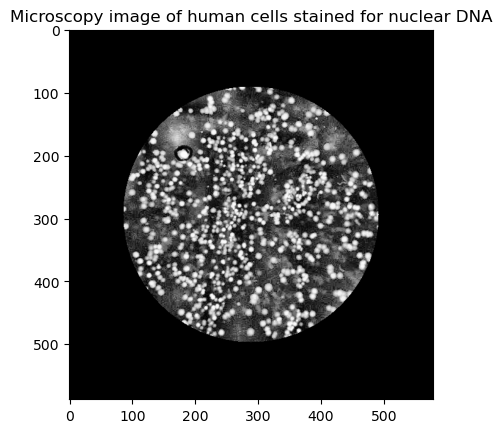

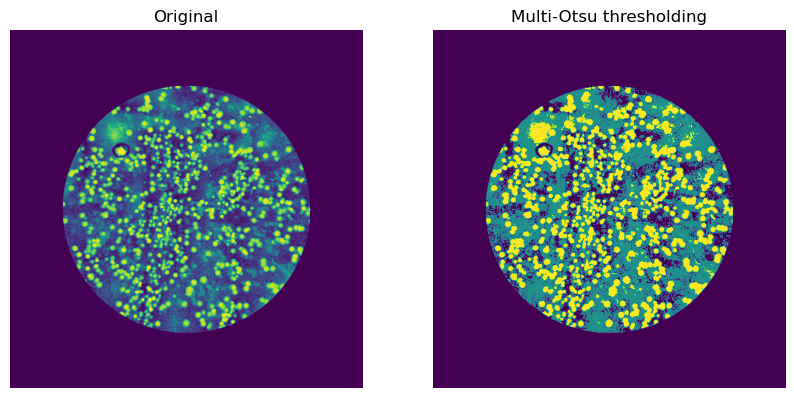

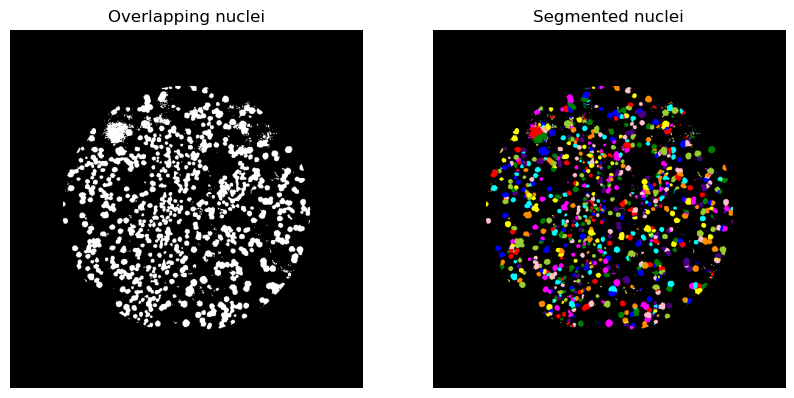

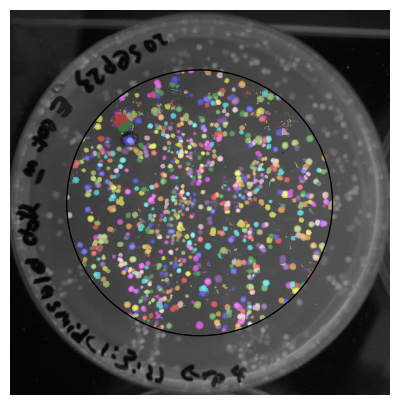

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi

from skimage import color, feature, filters, measure, morphology, segmentation, util

image = tophat1

fig, ax = plt.subplots()
ax.imshow(image, cmap="gray")
ax.set_title("Microscopy image of human cells stained for nuclear DNA")
plt.show()

thresholds = filters.threshold_multiotsu(image, classes=3)
regions = np.digitize(image, bins=thresholds)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title("Original")
ax[0].axis("off")
ax[1].imshow(regions)
ax[1].set_title("Multi-Otsu thresholding")
ax[1].axis("off")
plt.show()

cells = image > thresholds[1]

distance = ndi.distance_transform_edt(cells)

local_max_coords = feature.peak_local_max(distance, min_distance=1)
local_max_mask = np.zeros(distance.shape, dtype=bool)
local_max_mask[tuple(local_max_coords.T)] = True
markers = measure.label(local_max_mask)

segmented_cells = segmentation.watershed(-distance, markers, mask=cells)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(cells, cmap="gray")
ax[0].set_title("Overlapping nuclei")
ax[0].axis("off")
ax[1].imshow(color.label2rgb(segmented_cells, bg_label=0))
ax[1].set_title("Segmented nuclei")
ax[1].axis("off")
plt.show()

color_labels = color.label2rgb(segmented_cells, cropped, alpha=0.4, bg_label=0)

numCells = segmented_cells.max()
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(color_labels)
circle1 = plt.Circle(
    (width // 2, height // 2), round(0.35 * width), color="black", fill=False
)
ax.add_artist(circle1)
ax.set_axis_off()
plt.savefig(
    f"colony_counting/{imgName}_watershed_{numCells}.png",
    bbox_inches="tight",
    transparent=True,
)

plt.show()

In [12]:
cropped = cropWithROI(img, r)
# showImg(cropped)

cellsTh = (segmented_cells > 0).astype("uint8") * 255
redCellsTh = cv2.inRange(cropped, (0, 0, 180), (255, 255, 255))
redCellsTh = cv2.bitwise_and(redCellsTh, cellsTh)

displayImg = cropped.copy()
cnts, hierarchy = cv2.findContours(redCellsTh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
numRedCells = len(cnts)
cv2.drawContours(displayImg, cnts, -1, (0, 0, 255), 1)
cv2.circle(displayImg, (width // 2, height // 2), round(0.35 * width), (0, 0, 0), 2)
cv2.imwrite(f"colony_counting/{imgName}_threshold_{numRedCells}.jpg", displayImg)

True